# Pruebas con barrido de frecuencia

In [1]:
import threading
import time
import csv
import numpy as np
import sounddevice as sd
import serial
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
import matplotlib.pyplot as plt
from ordered_set import OrderedSet

In [2]:
ESP_COM_PORT = "COM23"
ESP_BAUDRATE = 115200
TIME_PERIOD = 0.125

In [3]:
# Frequencies taken from IEC 61672-1 and rounded to one decimal place
iec61672_freqs = (
    50.2, 63.1, 79.4, 100.0, 125.9, 158.5, 199.5, 251.2, 316.2, 
    398.1, 501.2, 631.0, 794.3, 1000.0, 1258.9, 1584.9, 1995.3, # Up to 2 kHz at 1/3-octave
    2238.7, 2511.9, 2818.4, 3162.3, 3548.1, 3984.1, 4466.8, 5011.9, 5623.4, 6309.6, 
    7079.5, 7943.3, # 2 to 8 kHz at 1/6-octave
    8414.0, 8912.5, 9440.6, 10000.0, 10593.0, 11220.0, 11885.0, 12589.0, 13335.0, 14125.0,
    14962.0, 15849.0, 16788.0, 17783.0, 18836.0, 19953.0 # Up to 20 kHz at 1/12-octave
)

ten_dB_spaced_volumes = (0.06, 0.13, 0.26, 0.51, 0.100) # 50 to 90 dB, in 10 dB intervals
ref_volume = 0.51 # 80 dB

freq_response_waves = {
    "frequencies": iec61672_freqs,
    "volumes": ten_dB_spaced_volumes
}

freq_sweep_waves = {
    "frequencies": (1000, 2000, 3000),
    "volumes": (0.03, 0.04, 0.05)
}

freq_weighting_waves = {
    "frequencies": iec61672_freqs,
    "volumes": ten_dB_spaced_volumes
}

In [4]:
# Get the default audio playback device
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
    IAudioEndpointVolume._iid_, CLSCTX_ALL, None)

# Create a volume control interface
volume_controller = cast(interface, POINTER(IAudioEndpointVolume))

In [5]:
# Variables for status syncronization between threads
current_freq = 0
current_volume = 0.0

In [6]:
class DataContainer(dict):
    # Format the data container for the specified test waves
    def __init__(self, test_waves, *args, **kwargs):
        super(DataContainer, self).__init__(*args, **kwargs)

        self.frequencies = OrderedSet()
        self.volumes = OrderedSet()
        self["all"] = np.array([])

        for freq in test_waves["frequencies"]:
            self.frequencies.add(freq)
            self[freq] = {}
            self[freq]["freq_all"] = np.array([])

            for volume in test_waves["volumes"]:
                self.volumes.add(volume)
                self[freq][volume] = np.array([])

In [15]:
# Function to receive serial data and store it
def receive_serial_data(data):
    ser = serial.Serial(ESP_COM_PORT, ESP_BAUDRATE)  # Replace 'COM1' with your serial port
    while not terminate_event.is_set():
        received_data = ser.readline().decode().strip()
        received_data = received_data.split(" ")[0]
        try:
            received_data = float(received_data)
        except ValueError:
            received_data = float(received_data.split(".")[0])
        try:
            if log_flag:
                data[current_freq][current_volume] = np.append(data[current_freq][current_volume], received_data)
            if freq_flag:
                data[current_freq]["freq_all"] = np.append(data[current_freq]["freq_all"], received_data)
            data["all"] = np.append(data["all"], received_data)
        except KeyError:
            pass
    ser.close()

# Function to play audio sine waves
def play_test_waves(test_waves):
    global current_freq, current_volume, log_flag, freq_flag

    duration = 2.5 if TIME_PERIOD == 0.125 else 20
    sample_rate = 88200
    t = np.arange(0, duration, 1 / sample_rate)

    for freq in test_waves["frequencies"]:
        current_freq = freq
        sine_wave = np.sin(2 * np.pi * freq * t)

        for n, volume in enumerate(test_waves["volumes"]):
            current_volume = volume
            print(f"now playing: {volume} volume @ {freq} Hz")

            log_flag = True
            if not freq_flag:
                freq_flag = True

            volume_controller.SetMasterVolumeLevelScalar(volume/10, None)

            # Wait before playing the sine wave
            time.sleep(0.375 if TIME_PERIOD == 0.125 else 3) #s

            sd.play(sine_wave, sample_rate, blocking=True)

            # Wait after playback is done
            time.sleep(0.375 if TIME_PERIOD == 0.125 else 3) #s

            log_flag = False
            if n == (len(test_waves["volumes"]) - 1):
                freq_flag = False

    # Send a signal to the other thread to terminate
    terminate_event.set()

In [8]:
# Doesn't sync the update times of the SLM and ESP, so it's not necessary
def play_sync_impulses():
    # Duration of the impulse in seconds
    duration = 0.375 if TIME_PERIOD == 0.125 else 3 # s
    sample_rate = 88200
    t = np.arange(0, duration, 1 / sample_rate)

    # Create an impulse signal
    impulse = np.sin(2 * np.pi * 1000 * t)

    # Wait before playing the impulse
    time.sleep(0.375 if TIME_PERIOD == 0.125 else 3) #s

    # Play the impulse
    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.3 if TIME_PERIOD == 0.125 else 2)

    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.6 if TIME_PERIOD == 0.125 else 4)

    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.375 if TIME_PERIOD == 0.125 else 3)

In [16]:
# Create formatted containers to store received serial data
freq_response_data = DataContainer(freq_response_waves)
freq_sweep_data = DataContainer(freq_sweep_waves)
freq_weighting_data = DataContainer(freq_weighting_waves)

# Event to signal termination
terminate_event = threading.Event()
# Flag to signal when to log measurements
log_flag = False
# Flag to signal the duration of a level progression for a certain frequency
freq_flag = False

## Ejecutar pruebas

In [ ]:
# *** Frequency response ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_response_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_response_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

In [17]:
# *** Frequency sweep ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_sweep_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_sweep_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

now playing: 0.03 volume @ 1000 Hz
now playing: 0.04 volume @ 1000 Hz
now playing: 0.05 volume @ 1000 Hz
now playing: 0.03 volume @ 2000 Hz
now playing: 0.04 volume @ 2000 Hz
now playing: 0.05 volume @ 2000 Hz
now playing: 0.03 volume @ 3000 Hz
now playing: 0.04 volume @ 3000 Hz
now playing: 0.05 volume @ 3000 Hz


In [ ]:
# *** Frequency weighting ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_weighting_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_weighting_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

## Guardar datos

In [ ]:
with open("data/sweep_tests/freq_response_f.pkl", 'wb') as file:
    pickle.dump(freq_response_data, file)

## Procesar datos del sonómetro

In [ ]:
# Convert the SLM reference data to the same format as the ESP measurements
reference = {}

## Analizar datos

In [42]:
# TODO: Delete
class TestDataContainer(dict):
    # Format the data container for the specified test waves
    def __init__(self, seed, *args, **kwargs):
        super(TestDataContainer, self).__init__(*args, **kwargs)

        self.frequencies = OrderedSet()
        self.volumes = OrderedSet()
        self["all"] = np.random.uniform(33, 92, size=(100,))

        for freq in (1000, 2000, 3000):
            self.frequencies.add(freq)
            self[freq] = {}
            self[freq]["freq_all"] = np.random.uniform(33, 92, size=(100,))

            for volume in (0.03, 0.04, 0.05):
                self.volumes.add(volume)
                self[freq][volume] = np.random.uniform(volume, volume+seed, size=(30,))

# Test datasets
test1 = TestDataContainer(5)
test2 = TestDataContainer(1)

In [50]:
# Plot the sound level progression with respect to time, for each frequency
def plot_time_progression(measurements, reference, units, title):
    for freq in measurements.frequencies:
        # Create x-axis values
        x_axis = [x * TIME_PERIOD for x in range(len(measurements[freq]["freq_all"]))]

        # Create a plot
        plt.plot(x_axis, measurements[freq]["freq_all"], label="ESP")
        plt.plot(x_axis, reference[freq]["freq_all"], label="SLM")

        # Add labels and a title (optional)
        plt.xlabel("s")
        plt.ylabel(units)
        plt.title(f"Sound level time progression @ {freq} Hz" + title)
        plt.legend()

        # Show the plot
        plt.show()

In [33]:
# Plot color map
def color_map(measurements, reference, function, title, function_units, weighted):
    # Create an empty matrix to store MAE values
    matrix = np.zeros((len(measurements.frequencies), len(measurements.volumes)))

    # Calculate MAE for all pairs of sets
    for i, freq in enumerate(measurements.frequencies):
        for j, volume in enumerate(measurements.volumes):
            matrix[i, j] = function(
                measurements[freq][volume],
                reference[freq][volume]
            )

    # Plot the MAE matrix as a colormap
    img = plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.xticks(range(len(measurements.volumes)), measurements.volumes)
    plt.yticks(range(len(measurements.frequencies)), measurements.frequencies)
    plt.xlabel("dBA" if weighted else "dB")
    plt.ylabel("Hz")
    cbar = plt.colorbar()
    cbar.set_label(function_units)
    plt.title(title)
    plt.show()

In [ ]:
def calculate_mae(measurements, reference):
    if len(measurements) != len(reference):
        raise ValueError("Both sets must have the same length")
    mae = np.mean(np.abs(measurements - reference))
    return mae

def calculate_rmse(measurements, reference):
    if len(measurements) != len(reference):
        raise ValueError("Input arrays must have the same length.")
    # Calculate the squared differences
    squared_diff = (measurements - reference) ** 2
    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diff)
    # Calculate the square root of the mean squared differences (RMSE)
    rmse = np.sqrt(mean_squared_diff)
    return rmse

def calculate_gain(measurements, reference):
    if len(measurements) != len(reference):
        raise ValueError("Both sets must have the same length")
    gain = np.mean(measurements - reference)
    return gain

In [ ]:
# Plot the frequency response of the measurements with respect to the reference, for the reference volume level
def plot_ref_gain(measurements, reference, ref_volume, units, title):
    gain = np.array([])

    for freq in measurements.frequencies:
        gain = np.append(gain, calculate_gain(measurements[freq][ref_volume], reference[freq][ref_volume]))

    # Create x-axis values
    x_axis = measurements.frequencies

    # Create a plot
    plt.plot(x_axis, gain)

    # Add labels and a title (optional)
    plt.xlabel("Hz")
    plt.xticks(measurements.frequencies, measurements.frequencies)
    plt.ylabel(f"Gain ({units})")
    plt.title(title)

    # Show the plot
    plt.show()

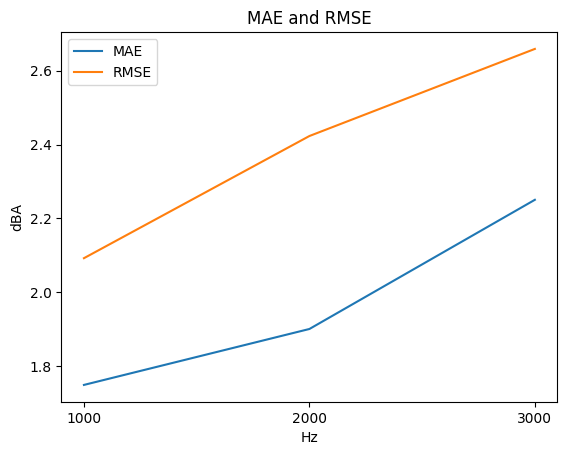

In [56]:
# Plot the MAE and RMSE of the measurements with respect to the reference, for the reference volume level
def plot_ref_MAE_RMSE(measurements, reference, ref_volume, units, title):
    mae = np.array([])
    rmse = np.array([])

    for freq in measurements.frequencies:
        mae = np.append(mae, calculate_mae(measurements[freq][ref_volume], reference[freq][ref_volume]))
        rmse = np.append(rmse, calculate_rmse(measurements[freq][ref_volume], reference[freq][ref_volume]))

    # Create x-axis values
    x_axis = measurements.frequencies

    # Create a plot
    plt.plot(x_axis, mae, label="MAE")
    plt.plot(x_axis, rmse, label="RMSE")

    # Add labels and a title (optional)
    plt.xlabel("Hz")
    plt.xticks(measurements.frequencies, measurements.frequencies)
    plt.ylabel(units)
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

plot_ref_MAE_RMSE(test1, test2, 0.04, "dBA", "MAE and RMSE")